# Word Embeddings Exercises



For this notebook we will be using the following packages

In [169]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
#import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

#Define some functions

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()


# Physics Abstracts Example

#Load in the Physics Abstracts:

In [171]:
apsDF = pandas.read_csv('data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


In [172]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [173]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk))

In [174]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documents since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [175]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 300) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [176]:
apsD2V.docvecs[1952]

array([ -1.95653006e-01,  -5.92306495e-01,  -1.29207354e-02,
        -1.53604457e-02,   4.28662121e-01,   9.09425735e-01,
        -4.89403069e-01,   4.89685535e-01,  -4.19765562e-01,
         6.70167387e-01,  -5.44113144e-02,   3.44074547e-01,
         2.21715346e-01,   2.36408323e-01,  -3.70887816e-01,
        -2.96005905e-01,   5.23761332e-01,  -5.19061506e-01,
        -8.92517507e-01,   5.05300403e-01,   3.32882367e-02,
        -1.02673936e+00,   5.65571666e-01,   7.95341134e-02,
        -8.25595021e-01,   1.43640625e+00,  -6.18587136e-02,
         9.69832480e-01,  -9.42612290e-02,  -9.30305719e-01,
        -6.66888773e-01,  -4.22725171e-01,   1.98421195e-01,
         4.95128572e-01,  -3.06392163e-01,  -2.10814372e-01,
         3.38922650e-01,   8.68928850e-01,   9.25914466e-01,
         2.58255333e-01,   5.36875367e-01,   3.63547772e-01,
        -2.98454136e-01,  -2.90146798e-01,   1.96585581e-02,
         1.69004902e-01,   5.07543445e-01,  -3.27224821e-01,
         1.65212944e-01,

The words can still be accessed in the same way:

In [177]:
apsD2V['atom']

array([  9.61767510e-02,   2.42272466e-01,  -1.26940548e-01,
        -4.06696618e-01,   7.43944496e-02,   1.71439692e-01,
        -4.70122099e-01,   1.25194803e-01,  -3.34290653e-01,
        -1.01473480e-01,  -3.99845205e-02,  -2.61299219e-02,
        -6.33912683e-01,   3.12294155e-01,  -3.94866467e-01,
         1.30879551e-01,   1.05886430e-01,   1.42680749e-01,
        -9.74310935e-02,  -4.39740531e-02,   2.41558209e-01,
        -2.34916300e-01,  -4.46478613e-02,  -1.55807361e-01,
        -5.35913706e-01,  -1.55867487e-02,   2.10038230e-01,
         4.49849129e-01,   5.91007471e-02,  -7.44550347e-01,
         5.40691257e-01,   2.07541481e-01,   2.62720585e-02,
         2.07182899e-01,   1.06483303e-01,   2.73832470e-01,
        -3.40922385e-01,  -2.31558899e-03,   2.02420741e-01,
         3.23611289e-01,  -8.99529979e-02,   1.30799860e-01,
        -6.77862987e-02,  -2.15453535e-01,   2.56186485e-01,
         3.07812005e-01,   3.62689525e-01,  -9.56939533e-02,
         8.43834803e-02,

We can still use the ``most_similar`` command to perform simple semantic equations:

In [179]:
apsD2V.most_similar('equation', topn = 10)

[('integral', 0.9595840573310852),
 ('grand', 0.9579411149024963),
 ('liouville', 0.9482520818710327),
 ('expansion', 0.9472519159317017),
 ('fourier', 0.9453361630439758),
 ('boltzmann', 0.9436877369880676),
 ('solved', 0.943208634853363),
 ('schrdinger', 0.9398786425590515),
 ('eigenfunction', 0.9379158020019531),
 ('expresses', 0.9360965490341187)]

In [180]:
apsD2V.most_similar(positive = ['electron','positive'], negative = ['negative'], topn = 10)

[('call', 0.8059724569320679),
 ('electrons', 0.7979356646537781),
 ('radiate', 0.7919137477874756),
 ('harmonically', 0.7783881425857544),
 ('dense', 0.7770719528198242),
 ('stream', 0.7750252485275269),
 ('interpenetrating', 0.7660356163978577),
 ('continually', 0.7609418034553528),
 ('ion', 0.7560607194900513),
 ('streams', 0.7531970143318176)]

In [181]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.100.1646', 0.682977557182312),
 ('10.1103/PhysRev.112.1429', 0.6818578243255615),
 ('10.1103/PhysRev.103.1202', 0.6766920685768127),
 ('10.1103/PhysRev.106.191', 0.675008237361908),
 ('10.1103/PhysRev.98.1584', 0.6698400974273682)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

In [183]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('centering', 0.8536929488182068),
 ('gyromagnetic', 0.8110805153846741),
 ('percent', 0.7564390301704407),
 ('gs', 0.7531020641326904),
 ('ratio', 0.7505196332931519)]

# Cultural Analysis - New York Times

In [184]:
nytimes_model = gensim.models.word2vec.Word2Vec.load_word2vec_format('data/nytimes_cbow.reduced.txt')

In [185]:
#words to create dimensions
tnytTargetWords = ['man','men','him','he', 'woman','women', 'her', 'she', 'Black','blacks','African','White', 'whites', 'Caucasian','European', 'rich', 'richer', 'richest', 'expensive', 'wealthy','wealth','poor', 'poorer', 'poorest', 'cheap', 'inexpensive','poverty']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.34313899, -0.117117  , -0.50773001, ..., -0.99569601,
         0.92129898,  0.94376898],
       [ 0.004427  , -0.57843202, -1.96249199, ..., -0.56563401,
         0.89292699,  0.186554  ],
       [-0.36290899, -0.26352799,  0.032661  , ..., -0.043032  ,
        -0.178965  ,  0.35355601],
       ..., 
       [-2.39162588, -1.90143001,  1.03118205, ...,  2.94746399,
         1.01587999,  2.00032997],
       [-2.43238711, -1.16141498,  1.06006396, ...,  4.40238094,
         0.500471  ,  1.64459598],
       [ 0.98193097,  0.62809402, -0.74754697, ...,  1.61292696,
         1.14806294,  1.06377602]], dtype=float32)

In [186]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [187]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Let's calculate three dimensions: gender, race, and class.

In [188]:
Gender = dimension(nytimes_model, ['man','men','him','he'], ['woman','women','her', 'she'])
Race = dimension(nytimes_model, ['Black','blacks','African','African'], ['White', 'whites', 'Caucasian','European'])
Class = dimension(nytimes_model, ['wealth','rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poverty','poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])
Politics = dimension(nytimes_model, ['Republican','Republicans', 'Conservative', 'conservative','conservatives'], ['Democrat','Democrats','Liberal','liberal', 'liberals'])


Here we have some words.

In [189]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Issues = ["war","climate","taxes","terrorism","immigration","trade","budget","Clinton","Bush"]

In [190]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    p = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
        p.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Politics.reshape(1,-1))[0][0])

    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c, 'politics': p}, index = word_list)
    return df

In [192]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)
Musicdf = makeDF(nytimes_model, Music)
Issuesdf = makeDF(nytimes_model, Issues)

Define some useful functions for plotting.

Plot the occupational words in each of the three dimensions.

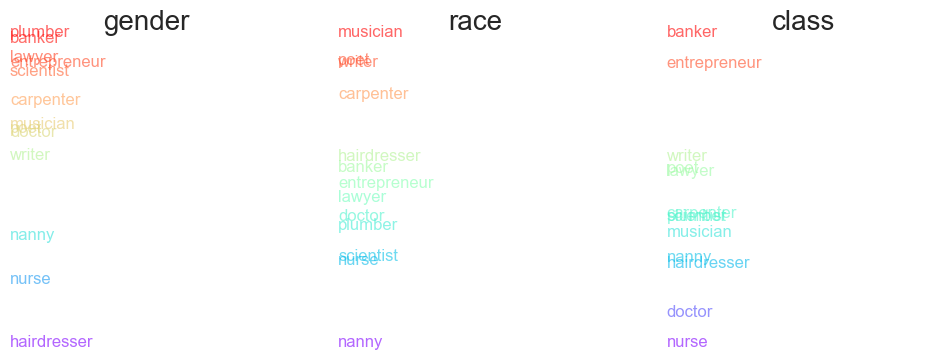

In [193]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

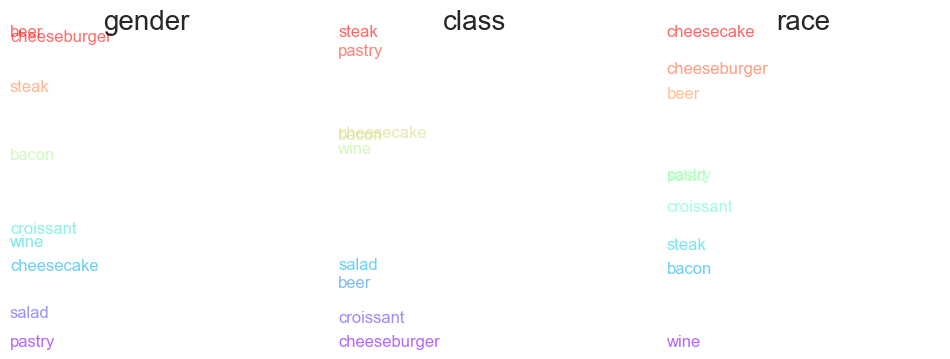

In [198]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'class')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'race')
plt.show()

Sports:

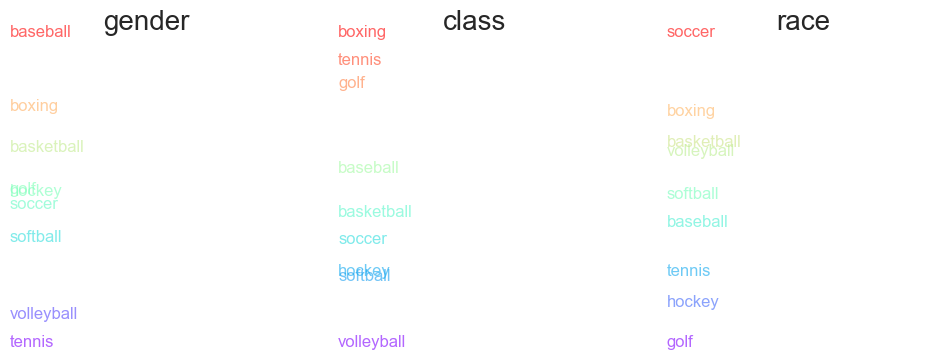

In [195]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'class')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'race')
plt.show()

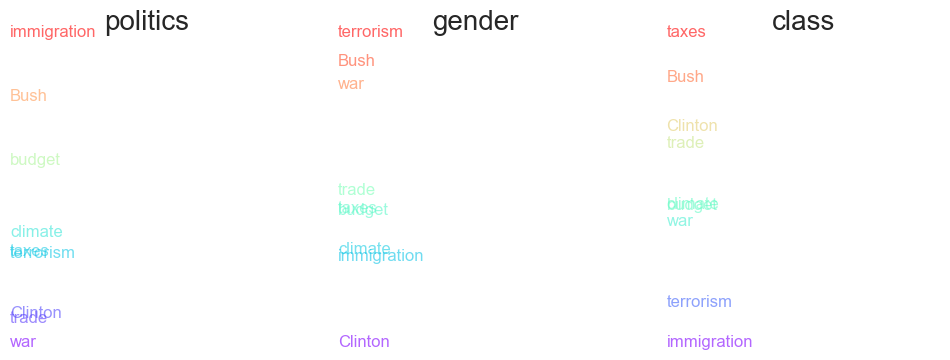

In [196]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Issuesdf, 'politics')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Issuesdf, 'gender')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Issuesdf, 'class')
plt.show()

In [204]:
sklearn.metrics.pairwise.cosine_similarity(Politics,Class)

C:\Users\Austin\Documents\ipython\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Austin\Documents\ipython\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.12582172]], dtype=float32)

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(Politics,Gender)